### Run this code with the Exp_1_WithoutObstacles.ttt Scene open

# IPC

In [2]:
from __future__ import print_function
import gym
import gym_kheperaposition
import numpy as np
import math
import sys
import matplotlib.pyplot as plt

Vmax=0.05
Wmax=math.pi/4

Kr_Prop=0.025   
K1=0.1
Kp=0.75
Ki=0.00007 
PI=3.1415 

def random_agent(steps=800):
    episode_reward = 0
    ErrorAcumulado=0
    env = gym.make('KheperaPositionControl-v0')
    env.MaxSteps = steps
    d, Oc = env.reset()
    #env.render()
    
    data = {}
    paso = []
    infoOc = []
    infoD = []
    Lineal = []
    Angular = []
    xc = []
    yc = []
    
    for e in range(steps):
        error = math.atan2(math.sin(Oc), math.cos(Oc))
        p = ((math.pi-math.fabs(error))/math.pi)
        v = min(K1*d*p, Vmax)
        if p > 0.9 and d > Kr_Prop:
            v = Vmax
        if d < Kr_Prop:
            v = 0
            w = 0
        ErrorAcumulado = error + ErrorAcumulado
        w = Kp*math.sin(Oc)+Ki*ErrorAcumulado
        Vl = (v-(w*0.1)/2)*48
        Vr = (v+(w*0.1)/2)*48
        action = [Vl, Vr]
        state, reward, done, info = env.step(action)
        d, Oc = state
        #env.render()
        #print(reward)
        print(reward, end='\r')
        sys.stdout.flush()
        
        episode_reward += reward
        x = info['xc']
        y = info['yc']
        
        paso.append(e)
        infoOc.append(float(Oc))
        infoD.append(float(d))
        Lineal.append(float(v))
        Angular.append(float(w))
        xc.append(float(x))
        yc.append(float(y))  
        
        if done:
            print('Reward of the episode is: ',episode_reward)
            break
    env.close()
   
    data={'paso' : paso,
          'Oc' : infoOc,
          'Distance' : infoD,
          'Lineal' : Lineal,
          'Angular' : Angular,
          'xc' : xc,
          'yc' : yc}
    
    #print(data)
    return data

data2 = random_agent()
d, t = [np.array(data2['Distance']), 0.05*np.array(data2['paso'])]

IAE = np.trapz(abs(d),t)
ISE = np.trapz(d**2,t)
ITAE = np.trapz(t*abs(d),t)
ITSE = np.trapz(t*(d**2),t)

IPC = [ISE, IAE, ITSE, ITAE]

print(IAE)
print(ISE)
print(ITAE)
print(ITSE)

Connected to remote API server
Reward of the episode is:  -260.0927454311125
23.423299006021416
22.618699359000612
254.32375989622085
195.92010996913334


# Villela

In [3]:
import gym
import gym_kheperaposition
import numpy as np
import math
import sys

Vmax=0.05
Wmax=math.pi/4
L=0.1
Kr_V_RL=0.05   # radio de seguridad

def random_agent(steps=900):
    episode_reward = 0
    env = gym.make('KheperaPositionControl-v0')
    env.MaxSteps = steps
    state = env.reset()
    d, Oc = state
    states = [] 
    #env.render()
    
    data = {}
    paso = []
    infoOc = []
    infoD = []
    Lineal = []
    Angular = []
    xc = []
    yc = []
    
    for e in range(steps):
        w = Wmax*math.sin(Oc)
        if d > Kr_V_RL:
            v = Vmax
        else:
            v = d*(Vmax/Kr_V_RL)
        if d < 0.02:
            v = 0
            w = 0
        states.append([state, e])
        Vl = (v-(w*0.1)/2)*48
        Vr = (v+(w*0.1)/2)*48
        action = [Vl, Vr]
        state, reward, done, info = env.step(action)
        d, Oc = state
        
        #env.render()
        #print(reward)
        print(reward, end='\r')
        sys.stdout.flush()
        episode_reward += reward
        
        x = info['xc']
        y = info['yc']
        
        paso.append(e)
        infoOc.append(float(Oc))
        infoD.append(float(d))
        Lineal.append(float(v))
        Angular.append(float(w))
        xc.append(np.array(x))
        yc.append(np.array(y))
        
        if done:
            print('Reward of the episode is: ',episode_reward)
            break
    
    env.close()
    data={'paso' : paso,
          'Oc' : infoOc,
          'Distance' : infoD,
          'Lineal' : Lineal,
          'Angular' : Angular,
          'xc' : xc,
          'yc' : yc
    }
    return data
data1 = random_agent()

d, t, v, w = [np.array(data1['Distance']), 0.05*np.array(data1['paso']), np.array(data1['Lineal']), np.array(data1['Angular'])]

IAE = np.trapz(abs(d),t)
ISE = np.trapz(d**2,t)
ITAE = np.trapz(t*abs(d),t)
ITSE = np.trapz(t*(d**2),t)

Villela = [ISE, IAE, ITSE, ITAE]

print(IAE)
print(ISE)
print(ITAE)
print(ITSE)

Connected to remote API server
Reward of the episode is:  -397.475819064033
28.920151691732407
30.937851179969403
351.2943012791652
301.8176021943875


# DQN

In [4]:
import numpy as np
import gym
import gym_kheperaposition

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation, Flatten
from tensorflow.keras.optimizers import Adam

from rl.agents.dqn import DQNAgent
from rl.policy import LinearAnnealedPolicy, BoltzmannQPolicy, EpsGreedyQPolicy
from rl.memory import SequentialMemory
import matplotlib.pyplot as plt

ENV_NAME = 'KheperaPositionObstacleD-v0'

# Get the environment and extract the number of actions.
env = gym.make(ENV_NAME)
np.random.seed(123)
env.seed(123)
nb_actions = env.action_space.n
env.MaxSteps = 5000
env.Randomize = False
env.Movements = [[4.285,0.515],[2.4,2.4],[0.515,4.285]]

# Next, we build a very simple model.
model = Sequential()
model.add(Flatten(input_shape=(1,) + env.observation_space.shape))
model.add(Dense(512))
model.add(Activation('relu'))
model.add(Dense(512))
model.add(Activation('relu'))
model.add(Dense(256))
model.add(Activation('relu'))
model.add(Dense(nb_actions))
model.add(Activation('linear'))
print(model.summary())

# Finally, we configure and compile our agent. You can use every built-in tensorflow.keras optimizer and
# even the metrics!
memory = SequentialMemory(limit=1100000, window_length=1)
#policy = BoltzmannQPolicy()
policy = LinearAnnealedPolicy(EpsGreedyQPolicy(), attr='eps', value_max=1., value_min=0.1, value_test=.05,
                              nb_steps=1300000)
dqn = DQNAgent(model=model, nb_actions=nb_actions, memory=memory, nb_steps_warmup=10000,
               target_model_update=1e-2, policy=policy)
dqn.compile(Adam(lr=1e-3), metrics=['mae'])

from OwnCallbacks import TestLogger
dqn.load_weights('Weights/dqn.h5')
log_filename = 'test.pckl'
logger = [TestLogger()]

dqn.test(env, nb_episodes=1, visualize=False, callbacks=logger)
env.close()

import pickle
f = open(log_filename, 'rb')
data3 = pickle.load(f)
f.close()

d, t = [np.array(data3['Distance']), 0.05*np.array(data3['paso'])]

IAE = np.trapz(abs(d),t)
ISE = np.trapz(d**2,t)
ITAE = np.trapz(t*abs(d),t)
ITSE = np.trapz(t*(d**2),t)

print(IAE)
print(ISE)
print(ITSE)
print(ITAE)

DQN = [ISE, IAE, ITSE, ITAE]

Connected to remote API server
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten (Flatten)            (None, 12)                0         
_________________________________________________________________
dense (Dense)                (None, 512)               6656      
_________________________________________________________________
activation (Activation)      (None, 512)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 512)               262656    
_________________________________________________________________
activation_1 (Activation)    (None, 512)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 256)               131328    
_________________________________________________________________
activation_2 (Activation)

## DDPG

In [5]:
import numpy as np
import gym
import gym_kheperaposition
import tensorflow as tf
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Activation, Flatten, Input, Concatenate, BatchNormalization, Add
from tensorflow.keras import layers
from tensorflow.keras.optimizers import Adam
from rl.agents import DDPGAgent
from rl.memory import SequentialMemory
from rl.random import OrnsteinUhlenbeckProcess
from rl.callbacks import FileLogger, ModelIntervalCheckpoint
import math

# Se prepara el entorno
ENV_NAME = 'KheperaPositionObstacle-v0'
env = gym.make(ENV_NAME)
np.random.seed(123)
env.seed(123)
env.Randomize = False

env.Vmax=0.05
env.Wmax=math.pi/4

nb_actions = env.action_space.shape[0]
nb_observation = env.observation_space.shape[0]
max_Lin_Vel, max_Ang_Vel = env.action_space.high

# Se crean los modelos de Actor y Critic
inputs = Input(shape=(1,) + env.observation_space.shape, name='observation_input')
out = Flatten()(inputs)
out = Dense(512, activation="relu")(out)
out = Dense(512, activation="relu")(out)
out = Dense(512, activation="relu")(out)
Lin_Vel = Dense(1, activation="sigmoid")(out)
Ang_Vel = layers.Dense(1, activation="tanh")(out)
outputs = Concatenate()([Lin_Vel,Ang_Vel])

Actor = Model(inputs, outputs)
print(Actor.summary())

observation_input = Input(shape=(1,) + env.observation_space.shape, name='observation_input')
observation_inputs = Flatten()(observation_input)
observation_inputs = Dense(512, activation="relu")(observation_inputs)

action_input = Input(shape=nb_actions, name='action_input')

concat = Concatenate()([observation_inputs, action_input])

observation_out = Dense(512, activation="relu")(concat)
observation_out = Dense(512, activation="relu")(observation_out)
state_outputs = Dense(1, activation="linear")(observation_out)

Critic = Model([observation_input, action_input], state_outputs)
print(Critic.summary())

memory = SequentialMemory(limit=1000000, window_length=1)
random_process = OrnsteinUhlenbeckProcess(size=nb_actions, theta=.15, mu=0., sigma=.3)

agent = DDPGAgent(nb_actions=nb_actions, actor=Actor, critic=Critic, critic_action_input=action_input,
                  memory=memory, nb_steps_warmup_critic=5000, nb_steps_warmup_actor=5000,
                  random_process=random_process, gamma=.99, target_model_update=1e-3)

agent.compile(Adam(lr=.0005, clipnorm=1.), metrics=['mae'])

from OwnCallbacks import TestLogger
pesos = 'Weights/ddpg.h5'
agent.load_weights(pesos)
log_filename = 'test.pckl'
logger = [TestLogger()]

agent.test(env, nb_episodes=1, visualize=False, callbacks=logger)
env.close()

import pickle
f = open(log_filename, 'rb')
data4 = pickle.load(f)
f.close()

d, t = [np.array(data4['Distance']), 0.05*np.array(data4['paso'])]

IAE = np.trapz(abs(d),t)
ISE = np.trapz(d**2,t)
ITAE = np.trapz(t*abs(d),t)
ITSE = np.trapz(t*(d**2),t)

print(IAE)
print(ISE)
print(ITSE)
print(ITAE)

DDPG = [ISE, IAE, ITSE, ITAE]

Connected to remote API server
Model: "functional_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
observation_input (InputLayer)  [(None, 1, 12)]      0                                            
__________________________________________________________________________________________________
flatten_1 (Flatten)             (None, 12)           0           observation_input[0][0]          
__________________________________________________________________________________________________
dense_4 (Dense)                 (None, 512)          6656        flatten_1[0][0]                  
__________________________________________________________________________________________________
dense_5 (Dense)                 (None, 512)          262656      dense_4[0][0]                    
________________________________________________________

## Gráficos de Posición

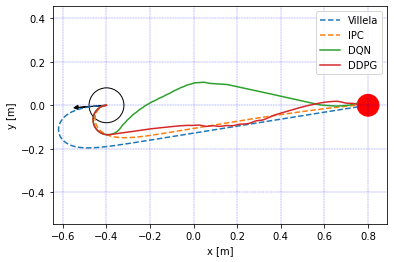

In [6]:
def set_xmargin(ax, left=0.0, right=0.3):
    ax.set_xmargin(0)
    ax.autoscale_view()
    lim = ax.get_xlim()
    delta = np.diff(lim)
    left = lim[0] - delta*left
    right = lim[1] + delta*right
    ax.set_xlim(left,right)

plt.show()
x1,y1 = [data1['xc'],data1['yc']]
x2,y2 = [data2['xc'],data2['yc']]
x3,y3 = [data3['xc'],data3['yc']]
x4,y4 = [data4['xc'],data4['yc']]
fig, ax = plt.subplots(figsize=(6,4))
ax.grid(True)
ax.grid(color='b', ls = '-.', lw = 0.25)
circle = plt.Circle((0.8, 0), .05, color='r')
circle2 = plt.Circle((-0.4,0), 0.08, color='k', fill=False)
ax.arrow(-0.4, 0, -0.13, -0.01, head_width=0.02, head_length=0.02, fc='k', ec='k')
ax.add_artist(circle)
ax.add_artist(circle2)
ax.plot(x1,y1, '--',label='Villela', color='tab:blue')
ax.plot(x2,y2, '--',label='IPC', color='tab:orange')
ax.plot(x3,y3, label='DQN', color='tab:green')
ax.plot(x4,y4, label='DDPG', color='tab:red')
ax.legend()
ax.axis('equal')
ax.set_xlabel('x [m]')
ax.set_ylabel('y [m]')
set_xmargin(ax, left=0.02, right=0.1)
#ax.margins(0.08,0)    
#fig.savefig('Position_Trajectories.svg', format='svg', dpi=1200)  

#fig.show()

## Gráficos de Velocidad Lineal y Angular

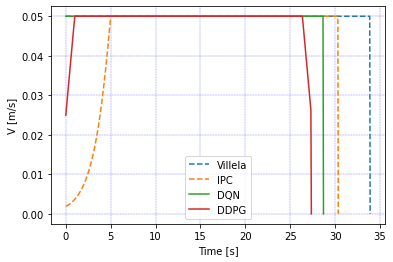

In [7]:
def smooth(y, box_pts=40):
    box = np.ones(box_pts)/box_pts
    y_smooth = np.convolve(y, box, mode='same')
    return y_smooth

v1,w1 = [data1['Lineal'], data1['Angular']]
v2,w2 = [data2['Lineal'], data2['Angular']]
v3,w3 = [data3['Lineal'], data3['Angular']]
v4,w4 = [data4['Lineal'], data4['Angular']]
v4 = smooth(v4)
w3 = smooth(w3)
w4 = smooth(w4)
w3 = smooth(w3)
w3 = smooth(w3)
w4 = smooth(w4)
w4 = smooth(w4)

v1[len(v1)-1] = 0
v2[len(v2)-1] = 0
v3[len(v3)-1] = 0
v4[len(v4)-1] = 0

t1 = np.array(data1['paso'])*0.05
t2 = np.array(data2['paso'])*0.05
t3 = np.array(data3['paso'])*0.05
t4 = np.array(data4['paso'])*0.05
plt.figure(figsize=(6,4))
plt.plot(t1,v1, '--',label='Villela')
plt.plot(t2,v2, '--',label='IPC')
plt.plot(t3,v3, label='DQN')
plt.plot(t4,v4, label='DDPG')
#plt.title('Velocidad Lineal')
plt.xlabel('Time [s]')
plt.ylabel('V [m/s]')
plt.legend()
plt.grid(color='b', ls = '-.', lw = 0.25)
#plt.savefig('Lineal_Velocity_position.svg', format='svg', dpi=1200)
plt.show()

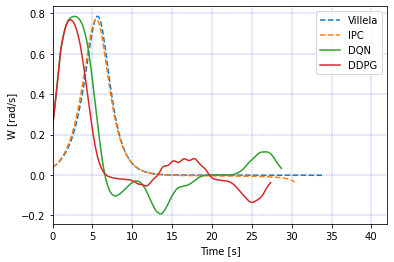

In [8]:
plt.figure(figsize=(6,4))
#w1 = [element * -1 for element in w1]
#w2 = [element * -1 for element in w2]
#w3 = [element * -1 for element in w3]
#w4 = [element * -1 for element in w4]
plt.plot(t1,w1,'--', label='Villela')
plt.plot(t2,w2, '--',label='IPC')
plt.plot(t3,w3, label='DQN')
plt.plot(t4,w4,label='DDPG')
#plt.title('Velocidad Angular')
plt.xlabel('Time [s]')
plt.ylabel('W [rad/s]')
plt.legend()
plt.grid(color='b', ls = '-.', lw = 0.25)
plt.xlim([0, 42]) 
#plt.ylim([-0.5, 0.81]) 
#plt.savefig('Angular_velocity_position.svg', format='svg', dpi=1200)
plt.show()

## Indices de Rendimiento

![](Performance_index.png)

In [9]:
# Datos paper "Simulation and Experimental Results of a New control..."

Villela_Paper = [30.77, 28.87, 299.35, 351.46]
IPC_Paper = [22.18, 23.28, 192.94, 255.00]

In [10]:
from tabulate import tabulate
Index = ['ISE','IAE','ITSE','IATE']
PerformanceIndex = {'Index':Index,
                    'Villela':Villela,
                    'IPC': IPC,
                    'DQN': DQN,
                    'DDPG' : DDPG}
PaperIndex = {'Villela' : Villela_Paper,
              'IPC': IPC_Paper}
print('Experimental Data')
print('')
print(tabulate(PerformanceIndex, headers='keys'))
print('')
print('Data from Paper')
print('')
print(tabulate(PaperIndex, headers='keys'))


Experimental Data

Index      Villela       IPC       DQN      DDPG
-------  ---------  --------  --------  --------
ISE        30.9379   22.6187   19.5274   18.0414
IAE        28.9202   23.4233   21.075    19.6635
ITSE      301.818   195.92    154.017   131.995
IATE      351.294   254.324   213.506   187.58

Data from Paper

  Villela     IPC
---------  ------
    30.77   22.18
    28.87   23.28
   299.35  192.94
   351.46  255


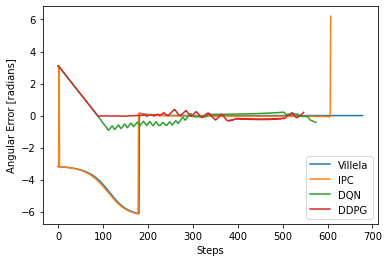

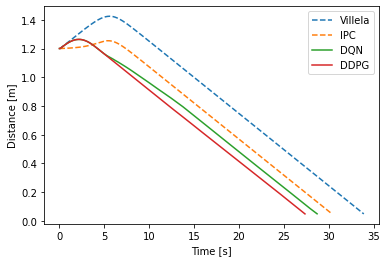

In [11]:
import matplotlib.pyplot as plt

plt.figure(figsize=(6,4))
plt.plot(data1['paso'],data1['Oc'], label='Villela')
plt.plot(data2['paso'],data2['Oc'], label='IPC')
plt.plot(data3['paso'],data3['Oc'], label='DQN')
plt.plot(data4['paso'],data4['Oc'], label='DDPG')
plt.xlabel('Steps')
plt.ylabel('Angular Error [radians]')
plt.legend()
plt.show()
plt.figure(figsize=(6,4))
plt.plot(t1,data1['Distance'],'--',label='Villela')
plt.plot(t2,data2['Distance'], '--',label='IPC')
plt.plot(t3,data3['Distance'], label='DQN')
plt.plot(t4,data4['Distance'], label='DDPG')
plt.xlabel('Time [s]')
plt.ylabel('Distance [m]')
plt.legend()
plt.savefig('Distance_position.svg', format='svg', dpi=1200)
#plt.savefig('Distance_position.png')
plt.show()

In [12]:
print('Villela: ' ,len(data1['paso'])*0.05)
print('IPC: ' ,len(data2['paso'])*0.05)
print('DQN: ' ,len(data3['paso'])*0.05)
print('DDPG: ' ,len(data4['paso'])*0.05)

Villela:  33.95
IPC:  30.400000000000002
DQN:  28.75
DDPG:  27.400000000000002
